Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from datetime import datetime
import joblib
from data import ImplicitData
import pandas as pd 
import numpy as np 
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from plot_utils import plot_n_users_per_bucket, plot_bucket_size
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [3]:
n_iter_bucket = 50E3

In [4]:
def get_bucket_map(eval_object:EvaluateAndStore):
    '''
    Create a dict that maps users (external id) to the buckets they are in (from 1 to last).
    '''
    user_bucket_map = {user:[] for user in eval_object.data.userset}
    for user in eval_object.data.userset:
        for i, bucket in enumerate( eval_object.holdouts ):
            if user in bucket.userset:
                user_bucket_map[user].append(i+1)
    return user_bucket_map

def median_user_presence_per_bucket(eval_object:EvaluateAndStore, user_bucket_map:dict):
    '''
    On median terms, on how many buckets a user is.
    '''
    presence_list = [len(user_bucket_map[user]) for user in eval_object.data.userset]
    return np.median( presence_list )

def plot_bucket_size(eval_object, dataset_name, filename=None):
    bucket_size = pd.Series( [bucket.size for bucket in eval_object.holdouts] )
    bucket_size = bucket_size.reset_index()
    bucket_size.columns = ['Bucket', 'Size']
    bucket_size['Bucket'] = bucket_size['Bucket']+1
    plt.figure(figsize=(10,5))
    sns.barplot(x='Bucket', y='Size', data=bucket_size, color='b')
    # sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
    plt.title(f'Bucket size - {dataset_name}')
    if filename:
        plt.savefig(f'images/user_bucket_analysis/{filename}')

def store_user_presence(dataset_name, median_user_presence):
    with open('output/joblib_bucket_info_dump/median_user_presence.txt', 'a') as file:
        file.write(f'{dataset_name}: in median terms, users are present in {median_user_presence} bucket\n')

def plot_interactions_per_month(data, dataset_name):
    interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
    interactions_per_month.name = 'count'
    interactions_per_month=interactions_per_month.reset_index()
    fig, ax = plt.subplots(figsize=(6,10))
    fig = sns.barplot(x='count', y='date', data=interactions_per_month, color='blue', ax=ax )
    ax.set_yticklabels(labels=list( interactions_per_month['date'].dt.year.astype(str) +'-'+ interactions_per_month['date'].dt.month.astype(str) ))
    plt.title(f'{dataset_name}: Interactions per year-month')
    plt.savefig(f'images/user_bucket_analysis/{dataset_name}_interactions_year_month.png')

# Store buckets

___
### Palco 2010

In [5]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/palco_2010.tsv","\t")

In [6]:
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

In [7]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [8]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [9]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_palco = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [10]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_palco.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 17 min

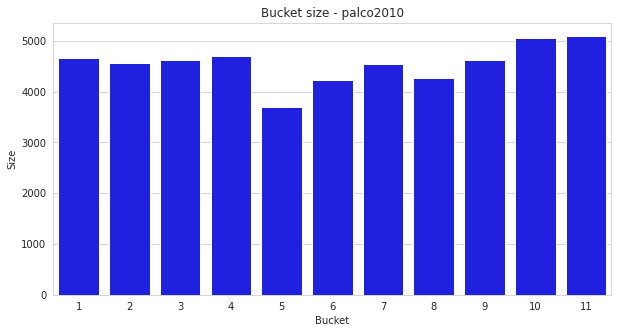

In [19]:
plot_bucket_size(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_bucket_size.png')

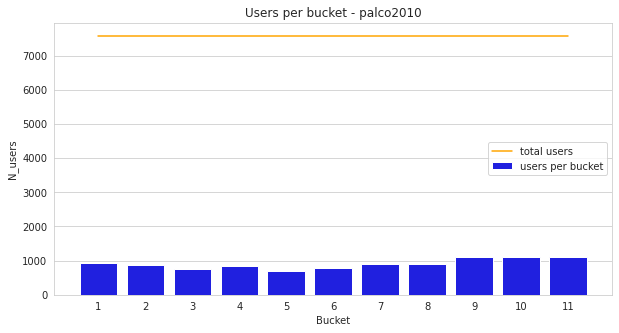

In [14]:
plot_n_users_per_bucket(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_user_per_bucket.png')

In [53]:
palco2010_ubm = get_bucket_map(eval_object=eval_palco)
palco2010_median_user_presence = median_user_presence_per_bucket(eval_object=eval_palco, user_bucket_map=palco2010_ubm)
print( palco2010_median_user_presence )
store_user_presence(dataset_name='palco2010',median_user_presence=palco2010_median_user_presence)

NameError: name 'eval_palco' is not defined

In [ ]:
joblib.dump(palco2010_ubm, 'output/joblib_bucket_info_dump/palco2010_ubm', compress=True)

['output/joblib_eval_objects_dump/palco2010_ubm']

___
### Movielens

In [5]:
# importa dataset 'movielensm1'
data = pd.read_csv("../datasets/ml1m_gte5.csv","\t")
data['date'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).date() )
data['year'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).year)
data['month'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).month )
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

How many interactions occur in each month?

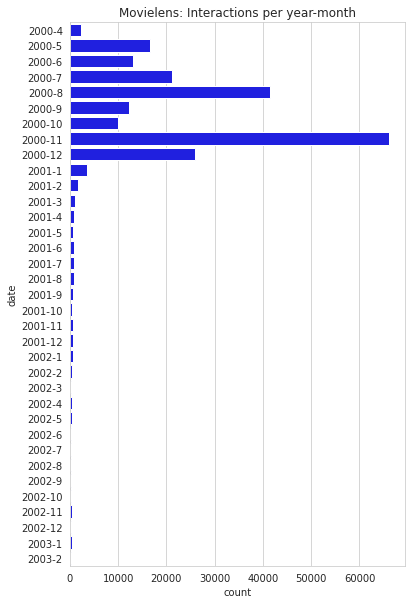

In [6]:
plot_interactions_per_month(data=data, dataset_name='Movielens')

Which users are frequent based on month, quarter, and semester?

In [7]:
#counting user interactions per month
user_month_interactions = data.groupby(by=['UserID', 'date']).count().iloc[:, 0]
user_month_interactions.name = 'count'
user_month_interactions = user_month_interactions.reset_index()
user_month_interactions.sort_values(by=['date'], ascending=[True], inplace=True)

In [8]:
# defining quarter and semester intervals in dataset

# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# https://stackoverflow.com/questions/69714505/how-can-generate-trimester-dates-in-python

from pandas import Timestamp, date_range
from pandas.tseries.offsets import MonthBegin, MonthEnd

start_ts, end_ts = Timestamp(user_month_interactions['date'].unique()[0]), Timestamp(user_month_interactions['date'].unique()[-1])
starts = date_range(start_ts, end_ts - MonthEnd(3), freq='3M') + MonthBegin(-1)
# starts = date_range(start_ts, end_ts, freq='3M') + MonthBegin(-1)
ends = date_range(start_ts + MonthEnd(3), end_ts, freq='3M')
trimestres = list(zip(starts, ends))

starts = date_range(start_ts, end_ts - MonthEnd(6), freq='6M') + MonthBegin(-1)
ends = date_range(start_ts + MonthEnd(6), end_ts, freq='6M')
semestres = list(zip(starts, ends))

In [9]:
# verifying user presence in months, quarter, and semester
user_presence_percentage = []
user_presence_map = []
for u in user_month_interactions['UserID'].unique():
    uidx = user_month_interactions['UserID'] == u
    month_presence = user_month_interactions.loc[uidx, 'date'].nunique() / user_month_interactions['date'].nunique()
    
    trimestre_presence = np.repeat(False, len(trimestres)+1 )
    semestre_presence = np.repeat(False, len(semestres)+1 )
    for udt in user_month_interactions.loc[uidx, 'date'].unique():

        idx = np.where( [ t[0]<=Timestamp( udt )<=t[1] for t in trimestres ] + [Timestamp( udt ) >= trimestres[-1][1]] )[0]
        trimestre_presence[idx] = True

        idx = np.where( [ t[0]<=Timestamp( udt )<=t[1] for t in semestres ] + [Timestamp( udt ) >= semestres[-1][1]] )[0]
        semestre_presence[idx] = True

    # storing trues and falses for each user ( here, we know exactly where user appears)
    user_presence_map.append( [u, user_month_interactions.loc[uidx, 'date'].unique(), trimestre_presence, semestre_presence] )
    # storing frequency in % of user occurence
    user_presence_percentage.append(
        [u, month_presence, sum(trimestre_presence)/len(trimestre_presence), sum(semestre_presence)/len(semestre_presence)] )

# building DF from presence percentage
user_presence_df = pd.DataFrame(
    user_presence_percentage,
    columns=['UserID', 'month_%', 'trimestre_%', 'semestre_%']
    ).sort_values(by='month_%', ascending=False)

In [42]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
5941,195,0.742857,0.833333,0.833333
3975,1088,0.685714,0.833333,0.833333
4950,1733,0.628571,0.833333,0.833333
5398,343,0.600000,0.833333,0.833333
5768,424,0.571429,0.833333,0.833333


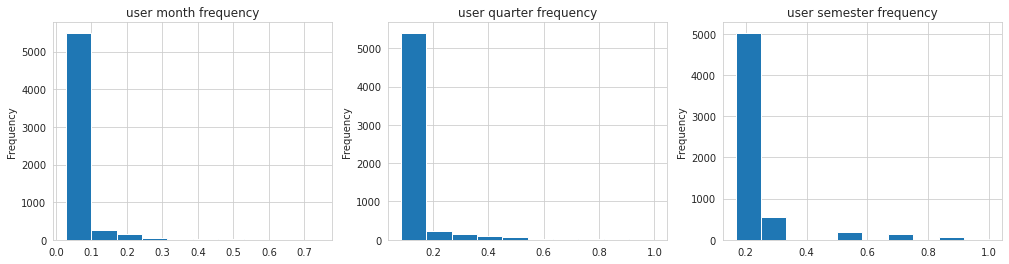

In [ ]:
# plotting user frequency distribution
fig, ax = plt.subplots(1,3, figsize=(17,4))
user_presence_df['month_%'].plot(kind='hist', ax=ax[0], title='user month frequency')
user_presence_df['trimestre_%'].plot(kind='hist', ax=ax[1], title='user quarter frequency')
user_presence_df['semestre_%'].plot(kind='hist', ax=ax[2], title='user semester frequency');

In [45]:
# defining threshold
frequency_threshold = 0.8

In [44]:
# getting frequent users per month
frequent_users_month = user_presence_df[user_presence_df['month_%']>=frequency_threshold ]['UserID'].values
print( frequent_users_month )
# percentage of users that are *frequent in months
100*len(frequent_users_month) / data['UserID'].nunique()

[]


0.0

In [43]:
# getting frequent users per quarter
frequent_users_trimestre = user_presence_df[user_presence_df['trimestre_%']>=frequency_threshold ]['UserID'].values
print( frequent_users_trimestre )
# percentage of users that are *frequent in quarters
100*len(frequent_users_trimestre) / data['UserID'].nunique()

[ 195 1088 1733  343  424 5948 2176 4802 5539]


0.14965081476554706

In [46]:
# getting frequent users per semester
frequent_users_semestre = user_presence_df[user_presence_df['semestre_%']>=frequency_threshold ]['UserID'].values
print( frequent_users_semestre )
# percentage of users that are *frequent in semesters
100*len( frequent_users_semestre ) / data['UserID'].nunique()

[ 195 1088 1733  343  424 4277 4823 1425 5948 2176 4802 1274 4126 5539
 2841  496 1451 5312 1421  624 5458 3203 4647 4258 1113 3688 4448 1551
 4579 2395 2859 4697 3054 4816 4600 1101 5359 3106 1980 3224  937 3285
 3391 1982 5450 5636  911 3158 5063 5090  953 1165 5250 3423 1202 4831
 4950   65 2969  146 5557 1203 3842 3080 2380 2810 3041 1352 2015 3125
 5394 5046 3368 1647 4861 4785 3592 1120 3562 3363 3971 4771 4085 5054
 5787 3471  239 3301 3590 5172 1500 5329 3259]


1.5463917525773196

In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [82]:
starts

DatetimeIndex(['2000-04-01', '2000-10-01', '2001-04-01', '2001-10-01',
               '2002-04-01'],
              dtype='datetime64[ns]', freq=None)

In [87]:
starts[1:]
labels = ['{}'.format(i.strftime('%Y-%m')) for i in starts[1:]]

In [104]:
pd.cut(data['date'], bins=starts, include_lowest=True) # , labels=labels

0         (2000-03-31 23:59:59.999999999, 2000-10-01]
1         (2000-03-31 23:59:59.999999999, 2000-10-01]
2         (2000-03-31 23:59:59.999999999, 2000-10-01]
3         (2000-03-31 23:59:59.999999999, 2000-10-01]
4         (2000-03-31 23:59:59.999999999, 2000-10-01]
                             ...                     
226305                                            NaN
226306                                            NaN
226307                                            NaN
226308                                            NaN
226309                                            NaN
Name: date, Length: 226310, dtype: category
Categories (4, interval[datetime64[ns]]): [(2000-03-31 23:59:59.999999999, 2000-10-01] < (2000-10-01, 2001-04-01] < (2001-04-01, 2001-10-01] < (2001-10-01, 2002-04-01]]

In [125]:
user=195
count = np.zeros( len( trimestres )+1 )
for d in user_month_interactions[ user_month_interactions['UserID'] == user ]['date']:
    count[ np.where( [ t[0]<=Timestamp( d )<=t[1] for t in trimestres ] + [Timestamp( d ) >= trimestres[-1][1]] )[0] ] += 1
count

array([0., 0., 1., 3., 3., 3., 3., 3., 3., 3., 3., 1.])

In [54]:
user_presence_map[195]

[5710,
 array(['2000-05-01T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([ True, False, False, False, False, False])]

In [47]:
for u in frequent_users_trimestre:
    

array([ 195, 1088, 1733,  343,  424, 5948, 2176, 4802, 5539])

In [480]:
trimestre_presence = np.repeat(False, len(trimestres)+1 )
for udt in user_month_interactions.loc[uidx, 'date'].unique():
    idx = np.where( [ t[0]<=Timestamp( udt )<=t[1] for t in trimestres ] + [Timestamp( udt ) >= trimestres[-1][1]] )[0]
    trimestre_presence[idx] = True

In [461]:
[[t[0]<=udt<=t[1] for udt in user_month_interactions.loc[uidx, 'date'].unique() ] for t in trimestres]
    # udt

[[False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False]]

In [ ]:
[ t[0]<=datest<=t[1] for t in trimestres ]

In [431]:

[ t[0]<=datest<=t[1] for t in trimestres ]


[False, True, False, False, False, False, False, False, False, False, False]

In [421]:
user_month_interactions.loc[user_month_interactions['UserID'] == 4958, 'date'].iloc[1]

Timestamp('2000-09-01 00:00:00')

In [415]:
user_month_interactions.loc[user_month_interactions['UserID'] == 4958, 'date'][8299]


Timestamp('2000-07-01 00:00:00')

In [ ]:
user_month_interactions[user_month_interactions['UserID'] == 4958]

In [327]:
user_month_interactions.loc[uidx, 'date'].nunique()

1

In [330]:
user_month_interactions['date'].nunique()/3

11.666666666666666

In [328]:
( user_month_interactions['date'].nunique() / 3)

11.666666666666666

In [324]:
user_presence_df

,UserID,month_presence,trimestre_presence,semestre_presence
5941,195,0.742857,2.228571,4.457143
3975,1088,0.685714,2.057143,4.114286
4950,1733,0.628571,1.885714,3.771429
5398,343,0.600000,1.800000,3.600000
5768,424,0.571429,1.714286,3.428571
...,...,...,...,...
2257,3530,0.028571,0.085714,0.171429
2252,3817,0.028571,0.085714,0.171429
2251,3515,0.028571,0.085714,0.171429
2250,3698,0.028571,0.085714,0.171429


In [155]:
sns.barplot(x='UserID', y='count',  hue='year-month', data=user_month_interactions, kind='bar')

KeyboardInterrupt: 

/home/klismam/.virtualenvs/dissertacao/lib/python3.6/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


KeyboardInterrupt: 

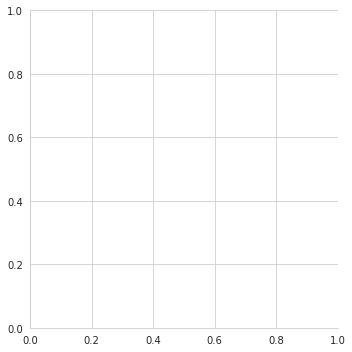

In [154]:
sns.factorplot(x='UserID', y='count', hue='year-month', data=user_month_interactions, kind='bar')

In [121]:
data.shape[050E3]

226310

In [118]:
trimestres = (data['date'].tail(1).values[0] - data['date'].head(1).values[0]).days/(3*30)

11.533333333333333

In [80]:
sns.lineplot(x='date', y='')

0         2000-04-26
1         2000-04-26
2         2000-04-26
3         2000-04-26
4         2000-04-26
             ...    
226305    2003-02-27
226306    2003-02-27
226307    2003-02-27
226308    2003-02-28
226309    2003-02-28
Name: date, Length: 226310, dtype: object

In [13]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

In [14]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [15]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [16]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_movielens = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [17]:
%%time
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_movielens.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 1:40 min

25 stored in 3
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
24 stored in 3
25 used in training
24 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 stored in 3
25 used in training
25 used in training
25 used in training
25 stored in 3
24 used in training
24 used in training
24 stored in 3
24 used in training
24 stored in 3
24 used in training
24 used in training
25 used in training
25 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
22 used in training
22 stored in 3
22 used in training
22 stored in 3
24 stored in 3
22 used in training
24 used in training
22 us

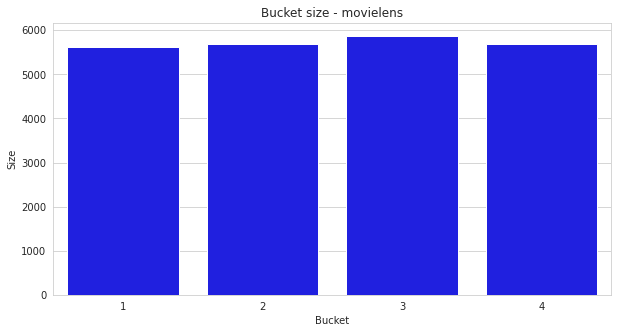

In [32]:
plot_bucket_size(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_bucket_size.png')

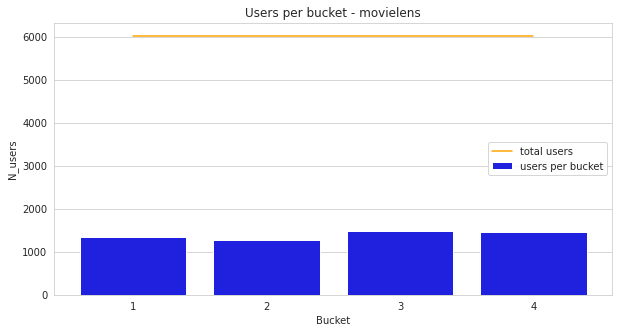

In [33]:
plot_n_users_per_bucket(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

In [57]:
movielens_ubm = get_bucket_map(eval_object=eval_movielens)
movielens_median_user_presence = median_user_presence_per_bucket(eval_object=eval_movielens, user_bucket_map=movielens_ubm)
print( movielens_median_user_presence )
store_user_presence(dataset_name='movielens', median_user_presence=movielens_median_user_presence)

In [55]:
joblib.dump(movielens_ubm, 'output/joblib_bucket_info_dump/movielens_ubm', compress=True)

['output/joblib_bucket_info_dump/movielens_ubm']

___

In [ ]:
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)

___
### Lastfm

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)

# Evaluation

In [ ]:
# def plot_n_users_per_bucket(eval_object:EvaluateAndStore, dataset_name:str, filename:str=None):
#     n_users = len( eval_object.data.userset )
#     n_users_bucket = pd.Series( [len( bucket.userset ) for bucket in eval_object.holdouts] )
#     n_users_bucket = n_users_bucket.reset_index()
#     n_users_bucket.columns = ['Bucket', 'N_users']
#     n_users_bucket['Bucket'] = n_users_bucket['Bucket']+1
#     plt.figure(figsize=(10,5))
#     sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
#     sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
#     plt.title(f'Users per bucket - {dataset_name}');
#     if filename:
#         plt.savefig(f'images/user_bucket_analysis/{filename}')

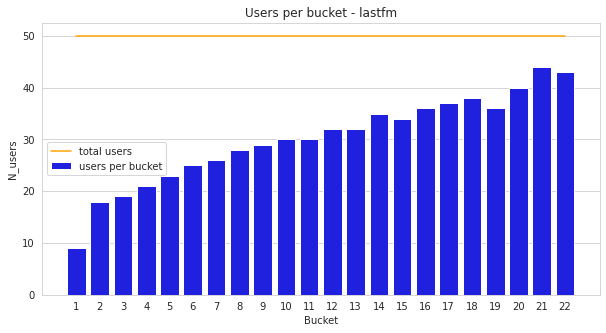

14.0

In [97]:
[bucket.userset for bucket in eval_lastfm.holdouts]

[array(['user_000174', 'user_000337', 'user_000407', 'user_000707',
        'user_000709', 'user_000751', 'user_000957', 'user_000984',
        'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000337', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000807', 'user_000882', 'user_000912', 'user_000957',
        'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000337', 'user_000374', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000767', 'user_000807', 'user_000882', 'user_000912',
        'user_000957', 'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000330', 'user_000337',
        'user_000374',

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange');

3784